In [1]:
import nltk 
from collections import defaultdict, Counter
from time import time
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
start_token, end_token = '^', '$'
tagged_sents = nltk.corpus.brown.tagged_sents(tagset='universal')
tagged_sents = [[(start_token, start_token)] + x + [(end_token, end_token)] for x in tagged_sents]

In [3]:
class HMM_POSTagger():
    def __init__(self):
        self.pos_counts = None
        self.word_tags = None
        self.trans_count = None

    def train(self, tagged_sents):
        all_tuples = [tup for sent in tagged_sents for tup in sent]
        self.pos_counts = Counter(pos for _, pos in all_tuples)
        self.word_tags = defaultdict(Counter)
        for word, pos in all_tuples:
            self.word_tags[word][pos] += 1
        self.trans_count = defaultdict(Counter)
        for sent in tagged_sents:
            for i in range(len(sent) - 1):
                self.trans_count[sent[i][1]][sent[i + 1][1]] += 1

    def eprob(self, tag, word):
        num = self.word_tags[word][tag]
        tot = self.pos_counts[tag]
        prob = (num + 1) / (tot + 1 + len(self.word_tags))
        return prob

    def tprob(self, tag1, tag2):
        num = self.trans_count[tag1][tag2]
        tot = self.pos_counts[tag1]
        prob = (num + 1) / (tot + len(self.pos_counts))
        return prob

    def viterbi(self, untagged_sent):
        t = len(untagged_sent)
        seq_sc = defaultdict(Counter)
        for tag in self.pos_counts:
            seq_sc[0][tag] = 0.0
        seq_sc[0][start_token] = 1.0
        
        bacptr = defaultdict(Counter)
        bacptr[0][start_token] = 0

        for i in range(1, t - 1):
            word = untagged_sent[i]
            for tag in self.pos_counts:
                seq_sc[1][tag] = 0.0
                for prev_tag in self.pos_counts:
                    state_prob = self.eprob(tag, word) * self.tprob(prev_tag, tag) * seq_sc[0][prev_tag]
                    if seq_sc[1][tag] < state_prob:
                        seq_sc[1][tag] = state_prob
                        bacptr[i][tag] = prev_tag
            for tag in self.pos_counts:
                seq_sc[0][tag] = seq_sc[1][tag]
    
        tags = [end_token for i in range(t)]
        for tag in self.pos_counts:
            if seq_sc[1][tag] > seq_sc[1][tags[t - 2]]:
                tags[t - 2] = tag
        for i in range(t - 3, 0, -1):
            tags[i] = bacptr[i + 1][tags[i + 1]]
        tags[0] = start_token
        return tags


In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tagged_sents = np.array(tagged_sents)
y_preds = []
y_trues = []
hmm_models = []

In [5]:
for fold, (train, test) in enumerate(kfold.split(tagged_sents)):
    train_sents = tagged_sents[train]
    test_sents = tagged_sents[test]
    hmm_models.append(HMM_POSTagger())
    hmm_models[-1].train(train_sents)
    y_pred, y_true = [], []
    for sent in tqdm(test_sents):
        untagged_sent = [word for word, tag in sent]
        pred = hmm_models[-1].viterbi(untagged_sent)
        for i in range(1, len(pred)-1):
            y_pred.append(pred[i])
            y_true.append(sent[i][1])
    y_preds.append(np.array(y_pred))
    y_trues.append(np.array(y_true))
    acc = np.sum(y_trues[-1] == y_preds[-1]) / len(y_trues[-1])
    print(f'Fold {fold + 1} Accuracy : {acc}')


Fold 1 Accuracy : 0.9324831885591853



Fold 2 Accuracy : 0.9314157287860684



Fold 3 Accuracy : 0.9306072404224656



Fold 4 Accuracy : 0.9315513257689632



Fold 5 Accuracy : 0.9318636063422446


In [13]:
# metrics start here
def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag in correct and tag == pred:
            correct[tag] += 1
        elif tag in wrong:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)

    thresh = np.max(plotMat) / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()

In [14]:
tagset = list(hmm_models[-1].pos_counts.keys())
tagset.remove(start_token)
tagset.remove(end_token)
tagset = sorted(tagset)
print(tagset)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [15]:
classes = tagset
class_names = None
report = None
support = None
cm, scores = None, None
cnt = 0
for y_true, y_pred in zip(y_trues, y_preds):
    class_names, report_, support_ = get_report(y_true, y_pred, classes)
    cm_ = confusion_matrix(y_true, y_pred, labels=classes)
    scores_ = get_scores(y_true, y_pred, classes)
    
    if report is None : report = np.zeros_like(report_, dtype=np.float64)
    report += report_
    
    if support is None : support = np.zeros_like(support_, dtype=np.float64)
    support += support_
    
    if cm is None : cm = np.zeros_like(cm_, dtype=np.float64)
    cm += cm_
    
    if scores is None : scores = np.zeros_like(scores_, dtype=np.float64)
    scores += scores_
    
    cnt += 1
    
report /= cnt
support /= cnt
cm /= cnt
scores /= cnt

<Figure size 432x288 with 0 Axes>

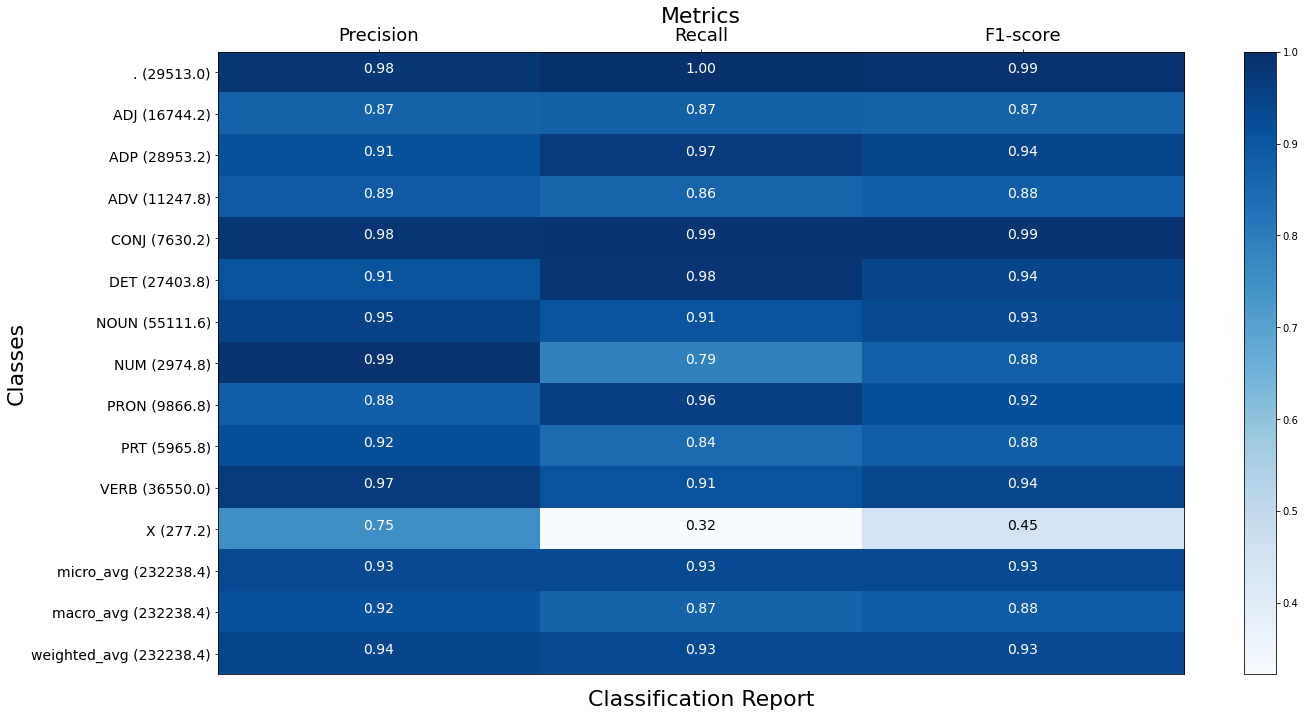

In [16]:
plot_clf_report(class_names, report, support)

<Figure size 432x288 with 0 Axes>

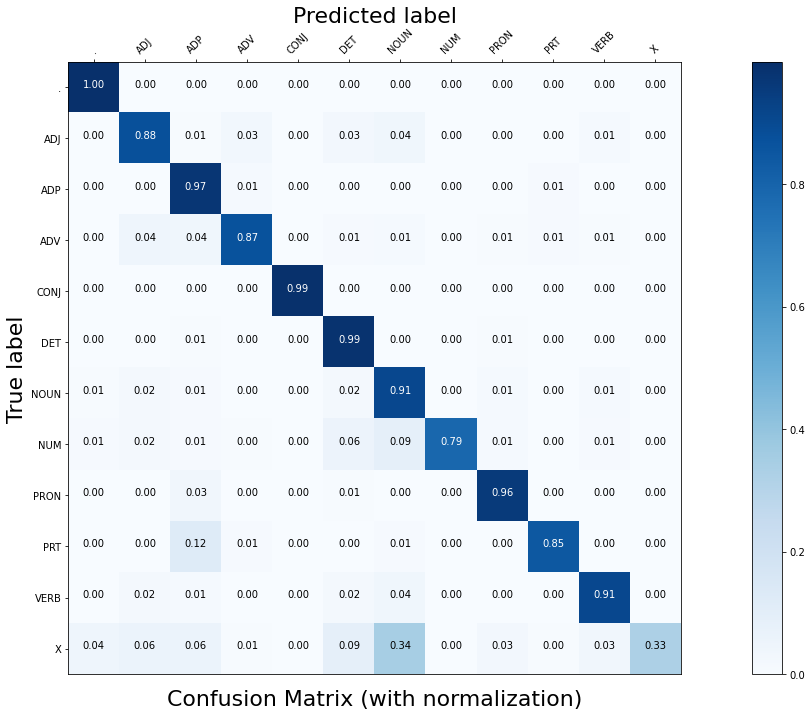

In [17]:
plot_confusion_matrix(classes, cm)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

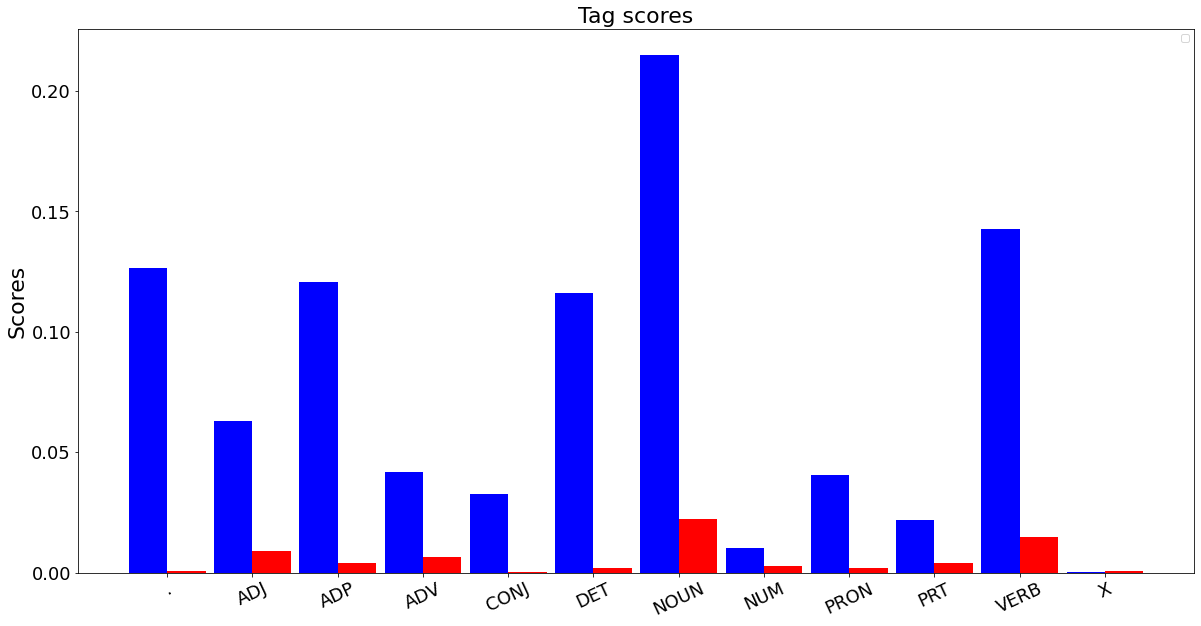

In [18]:
plot_tag_scores(classes, scores)